# Churn Prediction

In [17]:
import datetime as dt
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve
from xgboost import XGBClassifier

# Data loading and preprocessing
df = pd.read_csv("data/cleaned_online_retail_II.csv")
rfm_df = pd.read_csv("data/rfm_analysis.csv")
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], format="%Y-%m-%d %H:%M:%S")
analyse_date = df["InvoiceDate"].max() + dt.timedelta(days=1)

rfm_df.head()

,Customer ID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Segment,Cluster,Persona
0,12346,529,11,372.86,1,5,2,152,Loyal Customer,0,At-Risk & Lost
1,12347,2,8,4671.93,5,4,5,545,Recent Customer,1,Loyal & Valuable
2,12348,75,5,1659.40,3,4,4,344,Promising Customers,1,Loyal & Valuable
3,12349,19,3,3498.94,5,3,5,535,Recent Customer,1,Loyal & Valuable
4,12350,310,1,294.40,2,1,2,212,Regular Customer,0,At-Risk & Lost


In [18]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,30.0


In [19]:
# Set churn period as 3 months (90 days)
# Customers who haven't purchased in the last 90 days are considered churned
churn_window = 90

# Create churn label
# Recency > 90 means churned (1), else active (0)
rfm_df["Churn"] = rfm_df["Recency"].apply(lambda x: 1 if x > churn_window else 0)
rfm_df.head()

,Customer ID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Segment,Cluster,Persona,Churn
0,12346,529,11,372.86,1,5,2,152,Loyal Customer,0,At-Risk & Lost,1
1,12347,2,8,4671.93,5,4,5,545,Recent Customer,1,Loyal & Valuable,0
2,12348,75,5,1659.40,3,4,4,344,Promising Customers,1,Loyal & Valuable,0
3,12349,19,3,3498.94,5,3,5,535,Recent Customer,1,Loyal & Valuable,0
4,12350,310,1,294.40,2,1,2,212,Regular Customer,0,At-Risk & Lost,1


Customer Churn Rate:
Churn
1    50.722394
0    49.277606
Name: proportion, dtype: float64


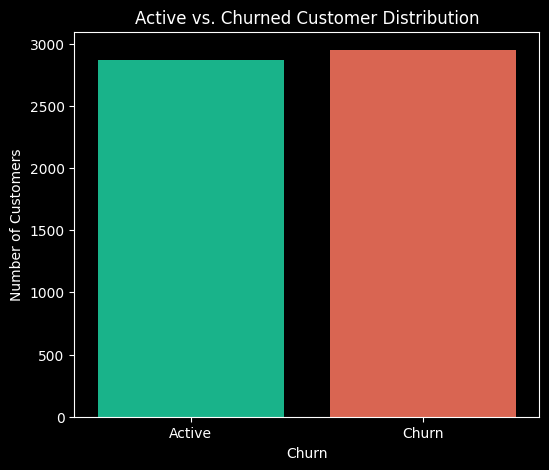

In [20]:
# Check churn rate to see if the dataset is imbalanced
churn_rate = rfm_df["Churn"].value_counts(normalize=True) * 100
print("Customer Churn Rate:")
print(churn_rate)

# Visualize churn distribution
plt.figure(figsize=(6, 5))
sns.countplot(
    x="Churn", data=rfm_df, hue="Churn", palette=["#00cc96", "#EF553B"], legend=False
)
plt.title("Active vs. Churned Customer Distribution")
plt.xticks([0, 1], ["Active", "Churn"])
plt.ylabel("Number of Customers")
plt.show()

In [21]:
# Find customer's first purchase date
first_purchase = df.groupby("Customer ID")["InvoiceDate"].min().reset_index()
first_purchase.columns = ["Customer ID", "FirstPurchaseDate"]

# Merge with main RFM dataset
rfm = pd.merge(rfm_df, first_purchase, on="Customer ID")

# Calculate tenure (customer age) in days
rfm["Tenure"] = (analyse_date - rfm["FirstPurchaseDate"]).dt.days

# Average Order Value (AOV)
rfm["AvgOrderValue"] = rfm["Monetary"] / rfm["Frequency"]

# Drop FirstPurchaseDate column
rfm.drop("FirstPurchaseDate", axis=1, inplace=True)

display(rfm.head())

# Show statistics of new features
display(rfm[["Tenure", "AvgOrderValue"]].describe())

,Customer ID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Segment,Cluster,Persona,Churn,Tenure,AvgOrderValue
0,12346,529,11,372.86,1,5,2,152,Loyal Customer,0,At-Risk & Lost,1,726,33.896364
1,12347,2,8,4671.93,5,4,5,545,Recent Customer,1,Loyal & Valuable,0,404,583.991250
2,12348,75,5,1659.40,3,4,4,344,Promising Customers,1,Loyal & Valuable,0,438,331.880000
3,12349,19,3,3498.94,5,3,5,535,Recent Customer,1,Loyal & Valuable,0,589,1166.313333
4,12350,310,1,294.40,2,1,2,212,Regular Customer,0,At-Risk & Lost,1,310,294.400000


,Tenure,AvgOrderValue
count,5814.000000,5814.000000
mean,473.731682,335.235590
std,223.301791,330.797864
min,1.000000,2.900000
25%,311.000000,171.726538
50%,529.000000,269.781250
75%,667.000000,396.285833
max,739.000000,8951.260000


In [22]:
rfm.head()

,Customer ID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Segment,Cluster,Persona,Churn,Tenure,AvgOrderValue
0,12346,529,11,372.86,1,5,2,152,Loyal Customer,0,At-Risk & Lost,1,726,33.896364
1,12347,2,8,4671.93,5,4,5,545,Recent Customer,1,Loyal & Valuable,0,404,583.991250
2,12348,75,5,1659.40,3,4,4,344,Promising Customers,1,Loyal & Valuable,0,438,331.880000
3,12349,19,3,3498.94,5,3,5,535,Recent Customer,1,Loyal & Valuable,0,589,1166.313333
4,12350,310,1,294.40,2,1,2,212,Regular Customer,0,At-Risk & Lost,1,310,294.400000


In [23]:
# 1. Separate Features and Target Variable
X = rfm.drop(
    [
        "Customer ID",
        "R_Score",
        "F_Score",
        "M_Score",
        "RFM_Score",
        "Segment",
        "Cluster",
        "Churn",
        "Recency",
        "Persona",
    ],
    axis=1,
)
y = rfm["Churn"]

# 2. Split into Training and Test Sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

# 3. Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

print("Scaled Training Data:")
display(X_train_scaled.head())

Training set size: (4651, 4)
Test set size: (1163, 4)
Scaled Training Data:


,Frequency,Monetary,Tenure,AvgOrderValue
0,-0.326552,-0.179413,0.936506,0.510163
1,0.299464,0.031976,0.474505,-0.215955
2,0.221212,0.456655,0.891652,0.927648
3,-0.013544,-0.013553,0.532816,0.129820
4,-0.170048,-0.197497,-1.615715,-0.341121


In [24]:
# Create and train Logistic Regression model
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train_scaled, y_train)

# Make predictions on test set
y_pred_log_reg = log_reg.predict(X_test_scaled)
y_pred_proba_log_reg = log_reg.predict_proba(X_test_scaled)[:, 1]

In [25]:
# Create and train Random Forest model
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_clf.fit(X_train_scaled, y_train)

# Make predictions on test set
y_pred_rf = rf_clf.predict(X_test_scaled)
y_pred_proba_rf = rf_clf.predict_proba(X_test_scaled)[:, 1]

In [26]:
# Create and train the XGBoost model
xgb_clf = XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)
xgb_clf.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred_xgb = xgb_clf.predict(X_test_scaled)
y_pred_proba_xgb = xgb_clf.predict_proba(X_test_scaled)[:, 1]

In [27]:
def evaluate_model(y_true, y_pred, y_pred_proba, model_name, ax=None):
    """Evaluate and visualize model performance."""
    print(f"--- {model_name} Evaluation Results ---")

    # Classification Report
    print("Classification Report:")
    print(classification_report(y_true, y_pred))

    # ROC AUC Score
    auc_score = roc_auc_score(y_true, y_pred_proba)
    print(f"ROC AUC Score: {auc_score:.4f}")

    # Confusion Matrix Visualization
    if ax is not None:
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(
            cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            cbar=False,
            ax=ax,
            xticklabels=["Active", "Churn"],
            yticklabels=["Active", "Churn"],
        )
        ax.set_title(f"{model_name} - Confusion Matrix")
        ax.set_xlabel("Predicted")
        ax.set_ylabel("Actual")

--- Logistic Regression Evaluation Results ---
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.77      0.79       573
           1       0.79      0.83      0.81       590

    accuracy                           0.80      1163
   macro avg       0.80      0.80      0.80      1163
weighted avg       0.80      0.80      0.80      1163

ROC AUC Score: 0.8828
--- Random Forest Evaluation Results ---
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.83      0.82       573
           1       0.83      0.80      0.81       590

    accuracy                           0.82      1163
   macro avg       0.82      0.82      0.82      1163
weighted avg       0.82      0.82      0.82      1163

ROC AUC Score: 0.9108
--- XGBoost Evaluation Results ---
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       573
 

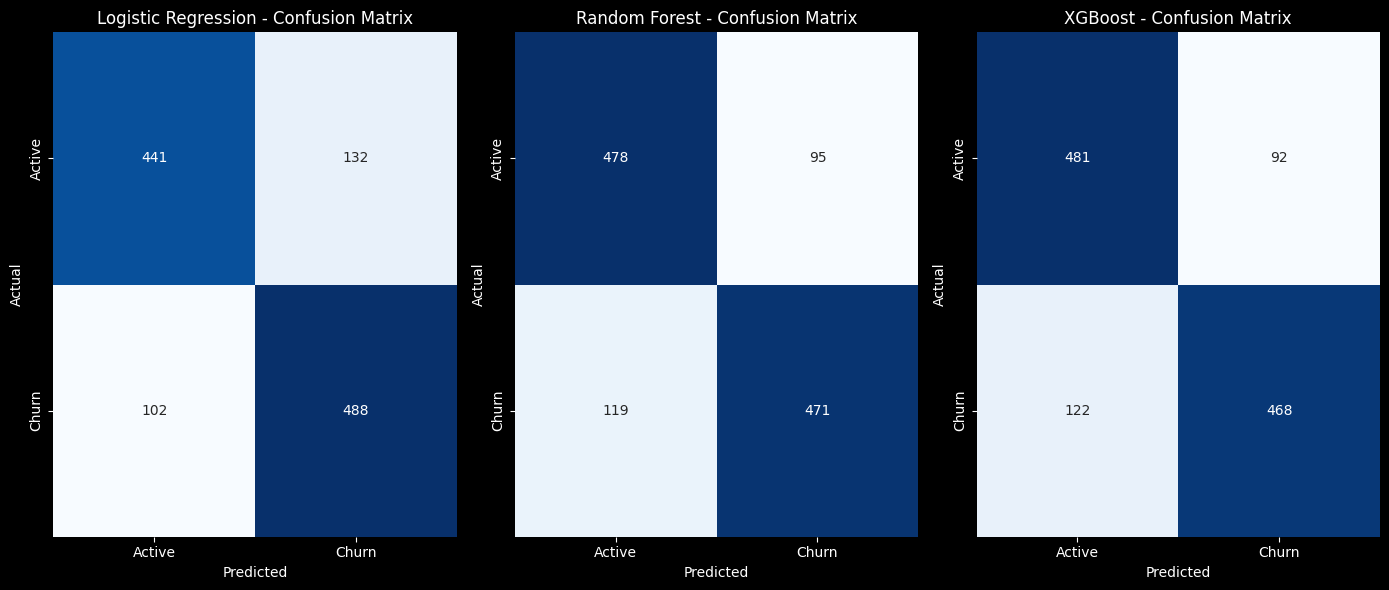

In [28]:
# Create a figure for confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(14, 6))

# Evaluate models and plot confusion matrices
evaluate_model(
    y_test, y_pred_log_reg, y_pred_proba_log_reg, "Logistic Regression", ax=axes[0]
)
evaluate_model(y_test, y_pred_rf, y_pred_proba_rf, "Random Forest", ax=axes[1])
evaluate_model(y_test, y_pred_xgb, y_pred_proba_xgb, "XGBoost", ax=axes[2])

plt.tight_layout()
plt.show()

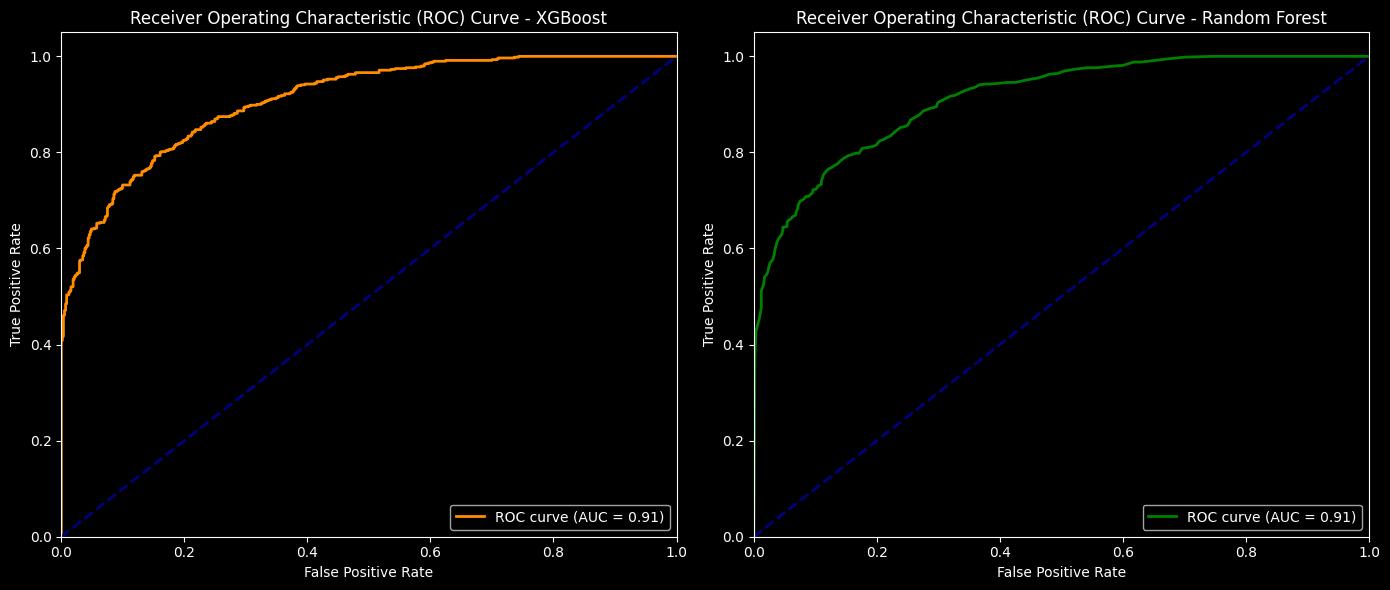

In [29]:
# ROC Curve for XGBoost and Random Forest
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# XGBoost ROC Curve
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)
auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)
ax1.plot(
    fpr_xgb, tpr_xgb, color="darkorange", lw=2, label=f"ROC curve (AUC = {auc_xgb:.2f})"
)
ax1.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel("False Positive Rate")
ax1.set_ylabel("True Positive Rate")
ax1.set_title("Receiver Operating Characteristic (ROC) Curve - XGBoost")
ax1.legend(loc="lower right")

# Random Forest ROC Curve
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
ax2.plot(fpr_rf, tpr_rf, color="green", lw=2, label=f"ROC curve (AUC = {auc_rf:.2f})")
ax2.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel("False Positive Rate")
ax2.set_ylabel("True Positive Rate")
ax2.set_title("Receiver Operating Characteristic (ROC) Curve - Random Forest")
ax2.legend(loc="lower right")

plt.tight_layout()
plt.show()

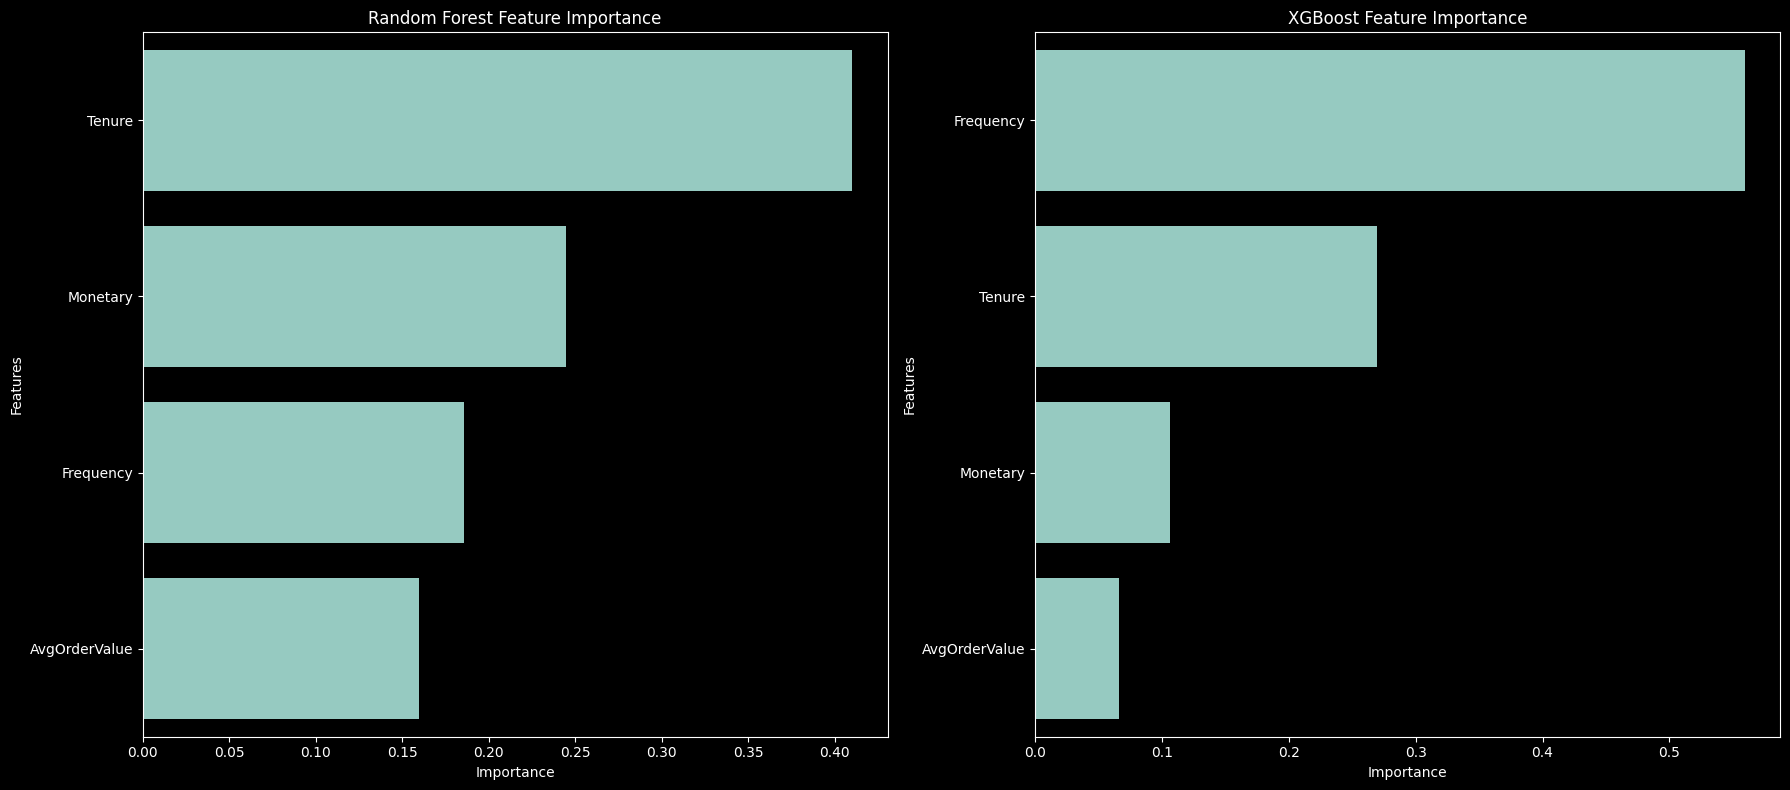

In [30]:
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Feature Importance for Random Forest
feature_imp_rf = pd.DataFrame(
    sorted(zip(rf_clf.feature_importances_, X.columns)), columns=["Value", "Feature"]
)
sns.barplot(
    x="Value",
    y="Feature",
    data=feature_imp_rf.sort_values(by="Value", ascending=False),
    ax=ax1,
)
ax1.set_title("Random Forest Feature Importance")
ax1.set_xlabel("Importance")
ax1.set_ylabel("Features")

# Feature Importance for XGBoost
feature_imp = pd.DataFrame(
    sorted(zip(xgb_clf.feature_importances_, X.columns)), columns=["Value", "Feature"]
)
sns.barplot(
    x="Value",
    y="Feature",
    data=feature_imp.sort_values(by="Value", ascending=False),
    ax=ax2,
)
ax2.set_title("XGBoost Feature Importance")
ax2.set_xlabel("Importance")
ax2.set_ylabel("Features")

plt.tight_layout()
plt.show()